In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [7]:
# Cargar datos
path_datos = os.path.join('..','..','Datos','Limpios')
df2 = pd.read_csv(os.path.join(path_datos,'datos2_limpios.csv'), index_col=0)

df2_limpio = df2.drop(['Porcentaje Ahorro (%)', 'Ahorro Actual (€)', 'Gasto Mensual (€)',
                        'Vida Esperada (años)', 'Edad de Jubilación'], axis=1)

In [8]:
# Definir variables de entrada y salida
X = df2_limpio.drop(columns=['Años Hasta Jubilación'])
y = df2_limpio['Años Hasta Jubilación']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modelos: AdaBoostRegressor, GradientBoostingRegressor, XGBRegressor y CatBoostRegressor

In [10]:
from xgboost import XGBRegressor

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
# Modelos iniciales
base_models = {
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor (random_state=42),
    #'XGBoost': XGBRegressor(random_state=42),
    #'CatBoost': CatBoostRegressor(random_state=42)
}

In [12]:
# Definir hiperparámetros para cada modelo
param_grid = {
    "AdaBoost": {'n_estimators': [120 ,150,180 ],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]},
    
    "GradientBoosting": {'n_estimators': [120 ,150,180 ],
    'max_depth': [2,4,7],
    'min_samples_split': [7, 10,15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]},
    #"XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]},
    #"CatBoost": {"iterations": [50, 100, 200], "depth": [4, 6, 8], "learning_rate": [0.01, 0.1, 0.2]}
}

In [13]:
best_models = {}
results = []

# 1️ Optimizar hiperparámetros para cada modelo
for name, model in base_models.items():
    print(f"Optimizing {name}...")
    grid = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_  # Guardamos el mejor modelo
    results.append({
        'model': name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })


Optimizing AdaBoost...
Optimizing GradientBoosting...


In [14]:
pd.DataFrame(results)

,model,best_score,best_params
0,AdaBoost,-1.476949,"{'learning_rate': 0.2, 'n_estimators': 180}"
1,GradientBoosting,-1.439857,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s..."


In [15]:
# 2️ Comparar modelos ya optimizados
final_results = []
for name, model in best_models.items():
    cv_score = cross_validate(model, X_train, y_train, scoring=['neg_mean_absolute_error', 'r2'], cv=5)
    
    mean_mae = np.mean(cv_score['test_neg_mean_absolute_error'])
    mean_r2 = np.mean(cv_score['test_r2'])
    
    final_results.append({
        'model': name,
        'MAE': mean_mae,
        'R2': mean_r2,
        'best_hyperparameters': grid.best_params_
    })



In [16]:
# 3️ Elegir el mejor modelo basado en MAE y R²
best_model = sorted(final_results, key=lambda x: x['MAE'], reverse=True)  # Ordenar por menor MAE
pd.DataFrame(best_model)

,model,MAE,R2,best_hyperparameters
0,GradientBoosting,-1.439857,0.981932,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s..."
1,AdaBoost,-1.476949,0.980783,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s..."


In [17]:
from lightgbm import LGBMRegressor

### Usar el modelo en dataset2

In [18]:
# Cargar nuevo dataset
df = pd.read_csv(os.path.join(path_datos, 'datos1_limpios.csv'), index_col=0)

In [19]:
X_2 = df.drop(['ID', 'FECHA NAC', 'SEXO', 'FECHA ENTRADA', 'PARA CONTAR MESES'], axis=1)
X_2.columns = ['Ingreso Anual (€)','Edad']
X_2 = X_2[['Edad','Ingreso Anual (€)']] 
X_2.head()

,Edad,Ingreso Anual (€)
0,51,15319.07
1,30,19168.80
2,52,18719.86
3,50,12942.60
4,49,20158.08


In [20]:
gb=  GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_split=10, n_estimators=180)
gb.fit(X_train, y_train) 

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_split=10,
                          n_estimators=180)

In [21]:
# Predecir
predicciones = gb.predict(X_2)
df['AÑOS HASTA JUBILACION'] = predicciones
df['EDAD DE JUBILACION'] = df['EDAD'] + df['AÑOS HASTA JUBILACION']
df['EDAD DE JUBILACION']

0     64.875350
1     64.291088
2     64.407294
3     64.472820
4     64.625826
        ...    
95    64.495733
96    64.132752
97    64.433146
98    64.566121
99    64.668723
Name: EDAD DE JUBILACION, Length: 100, dtype: float64

<Axes: >

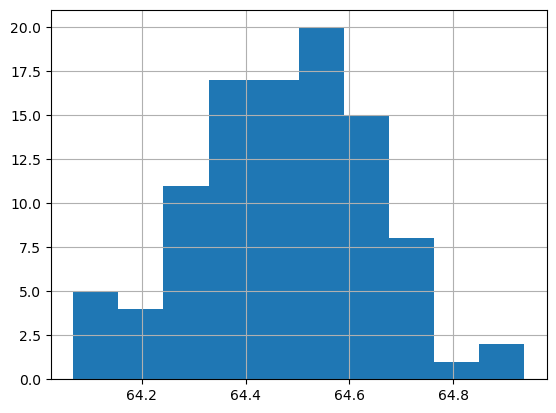

In [22]:
df['EDAD DE JUBILACION'].hist()